In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from sklearn.model_selection import train_test_split
from glob import glob

In [8]:
# create dataframe
def create_dataframe():

    file_paths = glob("../DATASET/archive/audio_data/train/*/*.wav")
    paths = []
    labels = []
    for file in file_paths:
        df_labels = file.split("/")[-2]
        labels.append(df_labels)
        paths.append(file)

    return paths, labels

In [9]:
paths, labels = create_dataframe()

In [11]:
len(paths)

800

In [12]:
len(labels)

800

In [17]:
data = pd.DataFrame({"file_paths":paths, "labels":labels})

In [18]:
data.head()

,file_paths,labels
0,../DATASET/archive/audio_data/train/pop/pop.00...,pop
1,../DATASET/archive/audio_data/train/pop/pop.00...,pop
2,../DATASET/archive/audio_data/train/pop/pop.00...,pop
3,../DATASET/archive/audio_data/train/pop/pop.00...,pop
4,../DATASET/archive/audio_data/train/pop/pop.00...,pop


In [20]:
data = data.sort_values(by="labels")

In [21]:
data.reset_index(inplace=True)

In [23]:
data.drop("index", axis=1, inplace=True)

In [24]:
data.head()

,file_paths,labels
0,../DATASET/archive/audio_data/train/blues/blue...,blues
1,../DATASET/archive/audio_data/train/blues/blue...,blues
2,../DATASET/archive/audio_data/train/blues/blue...,blues
3,../DATASET/archive/audio_data/train/blues/blue...,blues
4,../DATASET/archive/audio_data/train/blues/blue...,blues


In [32]:
# mfccs extraction to use ml
def mfccs_extraction(file):

    audio, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    scaled = np.mean(mfccs.T, axis=0)
    return scaled

In [33]:
data["mfccs"] = data.file_paths.apply(mfccs_extraction)

In [34]:
data.head()

,file_paths,labels,mfccs
0,../DATASET/archive/audio_data/train/blues/blue...,blues,"[-346.85635, 139.25108, 24.052633, 22.281025, ..."
1,../DATASET/archive/audio_data/train/blues/blue...,blues,"[-236.30539, 161.68063, -1.1661628, 27.27869, ..."
2,../DATASET/archive/audio_data/train/blues/blue...,blues,"[-209.80392, 124.46476, 10.309394, 47.016357, ..."
3,../DATASET/archive/audio_data/train/blues/blue...,blues,"[-288.7327, 105.90115, 18.776207, 23.682646, 5..."
4,../DATASET/archive/audio_data/train/blues/blue...,blues,"[-199.57513, 150.0861, 5.663404, 26.855282, 1...."


In [35]:
data_extracted = data.copy()

In [41]:
X = np.array(data_extracted["mfccs"].tolist())
y = np.array(data_extracted["labels"].tolist())

In [42]:
X.shape

(800, 40)

In [43]:
y.shape

(800,)

In [44]:
y = np.array(pd.get_dummies(y, dtype=int))

In [46]:
# train test splitting
X_train, X_test, y_train , y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [47]:
X_train.shape

(640, 40)

In [48]:
y_train.shape

(640, 10)

In [49]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [109]:
def evalution(model, model_name):
    prediction = model.predict_classes(X_test)
    accuracy = accuracy_score(y_test, prediction)
    f1_score_ = f1_score(y_test, prediction)
    print(classification_report(y_test, prediction))
    print("\naccuracy :", accuracy)
    print("\f1_score: ", f1_score_)

In [184]:
def preprocess_for_custom_input(file_path):
    audio, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    scaled = np.mean(mfccs.T, axis=0)
    return scaled

### MODEL SECTION

In [151]:
from keras.models import Sequential
from keras.layers import *
from keras.metrics import Recall, Precision
from keras.regularizers import l1
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [169]:
model = Sequential()
model.add(InputLayer((None, 40)))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation="softmax"))

In [170]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [171]:
ea = EarlyStopping(monitor="val_loss", mode="min", start_from_epoch=10, patience=30)
md = ModelCheckpoint("../models/music",save_best_only=True)

In [172]:
model.fit(x=X_train, y=y_train, batch_size=16, validation_data=(X_test, y_test), epochs=500, callbacks=[ea, md])

Epoch 1/500
21/40 [==============>...............] - ETA: 0s - loss: 12.6818 - accuracy: 0.1399 INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 2s 20ms/step - loss: 9.7817 - accuracy: 0.1719 - val_loss: 2.2573 - val_accuracy: 0.2625
Epoch 2/500
26/40 [==================>...........] - ETA: 0s - loss: 4.4040 - accuracy: 0.2500INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 4.0737 - accuracy: 0.2391 - val_loss: 1.8505 - val_accuracy: 0.3313
Epoch 3/500
26/40 [==================>...........] - ETA: 0s - loss: 2.8481 - accuracy: 0.3101INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 2.7714 - accuracy: 0.3016 - val_loss: 1.7399 - val_accuracy: 0.3875
Epoch 4/500
24/40 [=================>............] - ETA: 0s - loss: 2.3885 - accuracy: 0.2812INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 15ms/step - loss: 2.4209 - accuracy: 0.2703 - val_loss: 1.7046 - val_accuracy: 0.4062
Epoch 5/500
23/40 [================>.............] - ETA: 0s - loss: 2.1323 - accuracy: 0.3125INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 2.0722 - accuracy: 0.3313 - val_loss: 1.6830 - val_accuracy: 0.3875
Epoch 6/500
25/40 [=================>............] - ETA: 0s - loss: 2.0020 - accuracy: 0.3250INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.9688 - accuracy: 0.3297 - val_loss: 1.6359 - val_accuracy: 0.4062
Epoch 7/500
26/40 [==================>...........] - ETA: 0s - loss: 1.8346 - accuracy: 0.3822INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.8500 - accuracy: 0.3641 - val_loss: 1.6018 - val_accuracy: 0.4250
Epoch 8/500
27/40 [===================>..........] - ETA: 0s - loss: 1.8413 - accuracy: 0.3796INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.8301 - accuracy: 0.3703 - val_loss: 1.5603 - val_accuracy: 0.4437
Epoch 9/500
25/40 [=================>............] - ETA: 0s - loss: 1.8574 - accuracy: 0.4125INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 15ms/step - loss: 1.8326 - accuracy: 0.4016 - val_loss: 1.5399 - val_accuracy: 0.4375
Epoch 10/500
40/40 [==============================] - 0s 3ms/step - loss: 1.6812 - accuracy: 0.4078 - val_loss: 1.5623 - val_accuracy: 0.4563
Epoch 11/500
25/40 [=================>............] - ETA: 0s - loss: 1.6672 - accuracy: 0.4225INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.6706 - accuracy: 0.4266 - val_loss: 1.4895 - val_accuracy: 0.4375
Epoch 12/500
26/40 [==================>...........] - ETA: 0s - loss: 1.6281 - accuracy: 0.4207INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 15ms/step - loss: 1.5910 - accuracy: 0.4141 - val_loss: 1.4709 - val_accuracy: 0.4688
Epoch 13/500
25/40 [=================>............] - ETA: 0s - loss: 1.5066 - accuracy: 0.4550INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 15ms/step - loss: 1.5073 - accuracy: 0.4750 - val_loss: 1.4528 - val_accuracy: 0.4750
Epoch 14/500
26/40 [==================>...........] - ETA: 0s - loss: 1.5621 - accuracy: 0.4543INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 36ms/step - loss: 1.5568 - accuracy: 0.4484 - val_loss: 1.4162 - val_accuracy: 0.5562
Epoch 15/500
40/40 [==============================] - 0s 3ms/step - loss: 1.4947 - accuracy: 0.4781 - val_loss: 1.4188 - val_accuracy: 0.5250
Epoch 16/500
40/40 [==============================] - 0s 3ms/step - loss: 1.4266 - accuracy: 0.5047 - val_loss: 1.4208 - val_accuracy: 0.4938
Epoch 17/500
25/40 [=================>............] - ETA: 0s - loss: 1.4567 - accuracy: 0.4775INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.4298 - accuracy: 0.5000 - val_loss: 1.4074 - val_accuracy: 0.5375
Epoch 18/500
25/40 [=================>............] - ETA: 0s - loss: 1.3727 - accuracy: 0.5125INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.3458 - accuracy: 0.5125 - val_loss: 1.3355 - val_accuracy: 0.5250
Epoch 19/500
27/40 [===================>..........] - ETA: 0s - loss: 1.3405 - accuracy: 0.5255INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.3432 - accuracy: 0.5125 - val_loss: 1.2978 - val_accuracy: 0.5562
Epoch 20/500
40/40 [==============================] - 0s 3ms/step - loss: 1.2776 - accuracy: 0.5422 - val_loss: 1.2979 - val_accuracy: 0.5375
Epoch 21/500
28/40 [====================>.........] - ETA: 0s - loss: 1.2592 - accuracy: 0.5536INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.2306 - accuracy: 0.5641 - val_loss: 1.2847 - val_accuracy: 0.5500
Epoch 22/500
40/40 [==============================] - 0s 3ms/step - loss: 1.2599 - accuracy: 0.5547 - val_loss: 1.3356 - val_accuracy: 0.5312
Epoch 23/500
40/40 [==============================] - 0s 3ms/step - loss: 1.2107 - accuracy: 0.5875 - val_loss: 1.3611 - val_accuracy: 0.5188
Epoch 24/500
40/40 [==============================] - 0s 3ms/step - loss: 1.1550 - accuracy: 0.5984 - val_loss: 1.2877 - val_accuracy: 0.5250
Epoch 25/500
30/40 [=====================>........] - ETA: 0s - loss: 1.0848 - accuracy: 0.6146INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.1209 - accuracy: 0.5953 - val_loss: 1.2798 - val_accuracy: 0.5437
Epoch 26/500
28/40 [====================>.........] - ETA: 0s - loss: 1.0146 - accuracy: 0.6183INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.0720 - accuracy: 0.6141 - val_loss: 1.2610 - val_accuracy: 0.5312
Epoch 27/500
40/40 [==============================] - 0s 3ms/step - loss: 1.0891 - accuracy: 0.6172 - val_loss: 1.2869 - val_accuracy: 0.5688
Epoch 28/500
40/40 [==============================] - 0s 3ms/step - loss: 0.9994 - accuracy: 0.6562 - val_loss: 1.3179 - val_accuracy: 0.5500
Epoch 29/500
40/40 [==============================] - 0s 3ms/step - loss: 1.0535 - accuracy: 0.6328 - val_loss: 1.2767 - val_accuracy: 0.5437
Epoch 30/500
40/40 [==============================] - 0s 2ms/step - loss: 1.0032 - accuracy: 0.6578 - val_loss: 1.2991 - val_accuracy: 0.5250
Epoch 31/500
26/40 [==================>...........] - ETA: 0s - loss: 0.9747 - accuracy: 0.6635INFO:tensorflow:Assets written to: ../models/music/assets


INFO:tensorflow:Assets written to: ../models/music/assets


40/40 [==============================] - 1s 14ms/step - loss: 1.0008 - accuracy: 0.6500 - val_loss: 1.2042 - val_accuracy: 0.5688
Epoch 32/500
40/40 [==============================] - 0s 3ms/step - loss: 0.9024 - accuracy: 0.6875 - val_loss: 1.3185 - val_accuracy: 0.5688
Epoch 33/500
40/40 [==============================] - 0s 3ms/step - loss: 0.8967 - accuracy: 0.6875 - val_loss: 1.3034 - val_accuracy: 0.5750
Epoch 34/500
40/40 [==============================] - 0s 3ms/step - loss: 0.8616 - accuracy: 0.6938 - val_loss: 1.2741 - val_accuracy: 0.6062
Epoch 35/500
40/40 [==============================] - 0s 3ms/step - loss: 0.8828 - accuracy: 0.6766 - val_loss: 1.3929 - val_accuracy: 0.5375
Epoch 36/500
40/40 [==============================] - 0s 3ms/step - loss: 0.8283 - accuracy: 0.7219 - val_loss: 1.3094 - val_accuracy: 0.5625
Epoch 37/500
40/40 [==============================] - 0s 2ms/step - loss: 0.8296 - accuracy: 0.7094 - val_loss: 1.2508 - val_accuracy: 0.5750
Epoch 38/500
40/40

In [173]:
history_df = pd.DataFrame(model.history.history)

<Axes: title={'center': 'Loss graph'}, xlabel='epochs', ylabel='val'>

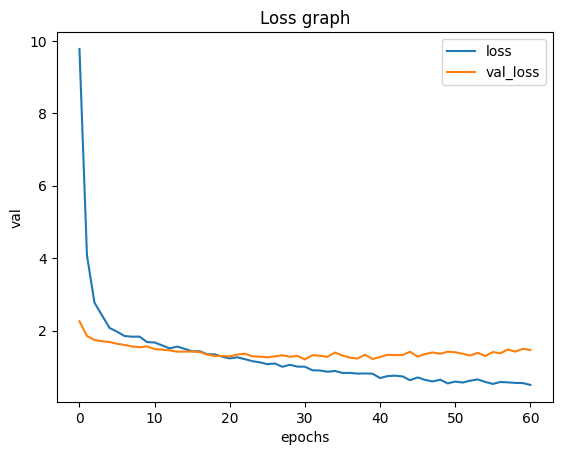

In [174]:
history_df[["loss", "val_loss"]].plot(title="Loss graph", xlabel="epochs", ylabel="val")

<Axes: title={'center': 'Accuracy graph'}, xlabel='epochs', ylabel='val'>

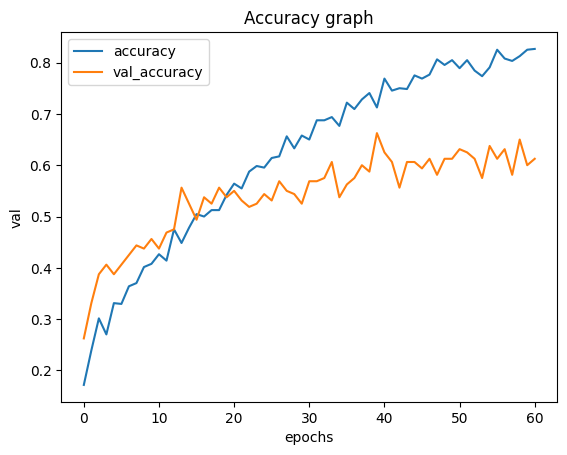

In [175]:
history_df[["accuracy", "val_accuracy"]].plot(title="Accuracy graph", xlabel="epochs", ylabel="val")

In [176]:
predict_classes = data.labels.unique()

In [177]:
from keras.models import load_model

In [178]:
loaded_model = load_model("../models/music")

In [180]:
loaded_model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 1.2042 - accuracy: 0.5688


[1.2042007446289062, 0.5687500238418579]

In [194]:
test_path = glob("../DATASET/archive/audio_data/test/*/*")

In [195]:
predicted_from_model = []
real = []
def serial_prediction():
    for file in test_path:
        custom_data = preprocess_for_custom_input(file_path=file)
        predicted = loaded_model(custom_data.reshape(1, 40))
        predicted_from_model.append(predict_classes[np.argmax(predicted)])
        real.append(file.split("/")[-2])

In [196]:
serial_prediction()

In [197]:
final_df = pd.DataFrame({"predicted":predicted_from_model, "real":real})

In [204]:
total = 0
true = 0
for yhat, y in zip(predicted_from_model, real):
    if yhat == y:
        true += 1
    total += 1
false = total-true

<BarContainer object of 3 artists>

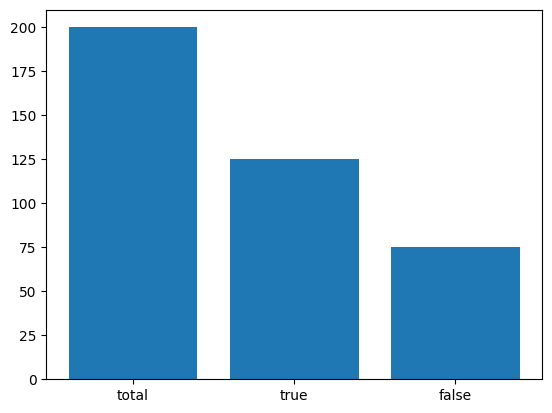

In [210]:
plt.bar(["total", "true", "false"], [total, true, false])

125